In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kernels
%matplotlib inline

In [2]:
kern = kernels.RBF()

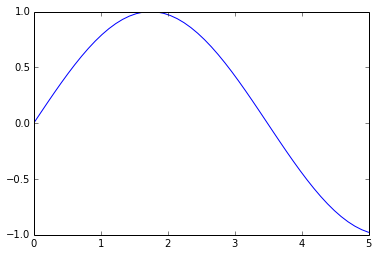

In [33]:
# Produce input and output
i = np.vstack(np.linspace(0, 5, 50))
    # Test 2D input data
#p = np.vstack(np.linspace(0, 10, 5))
#inputs = np.column_stack((i,p))
inputs = i
outputs = np.sin(0.9*inputs)

plt.figure()
plt.plot(i,outputs)
plt.show()

In [4]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection = '3d')
#ax.scatter(inputs[0], inputs[1], noisy_fn, zdir='noisy_fn')

In [38]:
# import kernels

class GP(object):

	def __init__(self, X, Y, Xn, Yn, kernel=None, normalize=True):
		self.X = X
		self.Y = Y
		self.Xn = Xn
		self.Yn = Yn
		self.kernel = kernel        
		#print self.X      
		if normalize is True: # works on 1D and 2D input
			mu = np.vstack(np.mean(X, axis=0))
			s = np.vstack(X.std(axis=0))
			centred = X.T - mu
			div = centred/s                       
			self.X = div.T
			#print mu
			#print s
			#print self.X      
		self.mean = mu
		self.sd = s
		if kernel is None: # Change Default_RBF to RBF once custom kernel constructed, delete Default_RBF class
			import warnings
			warnings.warn("Kernel not specified, defaulting to RBF kernel...")
			kernel = kernels.RBF()

        # Compute covariance matrix
		self.cov = kernel.compute(self.X, self.X)          
		#print self.cov
        
	def prior(self):   
		cov = self.cov  
		X = self.X # Resetting X to normalized inputs
		#print X
		mean = np.zeros((X.shape[0],1)) # 5x1
		#print mean.shape
		#print np.sqrt(np.diag(cov))
		noisy_cov = self.cov + (0.00005 * np.eye(self.cov.shape[0])) #5x5
		print noisy_cov
		L = np.linalg.cholesky(noisy_cov) # 5x5
		print L
		print np.dot(L, np.random.normal(size=(self.X.shape[0],10))) # 5x5 dot 5x10 = 5x10
		print mean + np.dot(L, np.random.normal(size=(self.X.shape[0],10))) # 5x10

	def plot_prior(self):
		        
		X = np.hstack(self.X) # for plotting
		mean = np.zeros(X.shape)
		noisy_cov = self.cov + (0.00005 * np.eye(self.cov.shape[0]))       
		s = np.sqrt(np.diag(noisy_cov))
		     
		#print noisy_cov        
		plt.figure()
		plt.xlim(min(X), max(X))
		plt.ylim(min(mean-(2*s)-(s/2)), max(mean+(2*s)+(s/2)))       
		plt.plot(X, self.Y, 'b-', label='Y')
		plt.plot(X, mean, 'r--', lw=2, label='mean')
		plt.fill_between(X, mean-(2*s), mean+(2*s), color='#87cefa')
		plt.legend()
		plt.show() 

		L = np.linalg.cholesky(noisy_cov)
		mean = mean.reshape(X.shape[0],1)
		f = mean + np.dot(L, np.random.normal(size=(self.X.shape[0],10)))
		plt.figure()
		plt.xlim(min(X), max(X))
		plt.plot(X, f)
		plt.title('Ten samples')
		plt.show() 
        
	def plot_posterior(self, Y, Xn, Yn, normalize=True): 
		original_input = self.X
		
		if normalize is True: # works on 1D and 2D input
			centred = Xn.T - self.mean
			div = centred/self.sd                       
			Xn = div.T
		
		Xn_cov = self.kernel.compute(Xn, Xn)
		cross_cov = self.kernel.compute(Xn, original_input)
		
		Lx = np.linalg.cholesky(Xn_cov + (0.00005 * np.eye(Xn_cov.shape[0])))
		tr_oldcov_to_cross = np.linalg.solve(Lx, cross_cov)
		
		mu = np.dot(tr_oldcov_to_cross.T, np.linalg.solve(Lx, Yn))
		cov_post = self.cov + (0.00005*np.eye(self.cov.shape[0])) - np.dot(tr_oldcov_to_cross.T, tr_oldcov_to_cross)
		s = np.sqrt(np.diag(cov_post))
		mean = mu.flat
		#print mu.shape
		X = np.hstack(original_input)
		
		
		LX = np.linalg.cholesky(self.cov + (0.00005 * np.eye(self.cov.shape[0])))
		#tr_oldcov_to_cross1 = np.linalg.solve(LX, cross_cov)
		
		inv = np.linalg.inv(self.cov + (0.00005*np.eye(self.cov.shape[0])))
		print cross_cov.shape
		print inv.shape
		
		mu0 = np.dot(cross_cov, inv)
		print mu0.shape
		print self.Y.shape
		mu2 = np.dot(cross_cov,inv,self.Y)
		#mu1 = np.dot(tr_oldcov_to_cross1.T, np.linalg.solve(LX, Yn))
		#cov_post1 = Xn_cov + (0.00005*np.eye(self.cov.shape[0])) - np.dot(tr_oldcov_to_cross1.T, tr_oldcov_to_cross1)
		#s1 = np.sqrt(np.diag(cov_post1))
		mean1 = mu2.flat
		
		        
		plt.figure()
		plt.plot(Xn, Yn, 'r+', ms=20) # new points
		plt.xlim(min(X), max(X))
		#plt.ylim(min(mean-(2*s)-(s/2)), max(mean+(2*s)+(s/2)))        
		plt.plot(X, Y, 'b-', label='Y') # true function
		plt.plot(X, mean, 'r--', lw=2, label='mean') # mean function
		#plt.fill_between(X, mean-(2*s), mean+(2*s), color='#87cefa') # uncertainty
		plt.legend()
		plt.show()
		       
		plt.figure()
		plt.plot(Xn, Yn, 'r+', ms=20) # new points
		plt.xlim(min(X), max(X))
		plt.ylim(min(mean1-(2*s1)-(s1/2)), max(mean1+(2*s1)+(s1/2)))        
		plt.plot(X, Y, 'b-', label='Y') # true function
		plt.plot(X, mean1, 'r--', lw=2, label='mean1') # mean function
		plt.fill_between(X, mean1-(2*s1), mean1+(2*s1), color='#87cefa') # uncertainty
		plt.legend()
		plt.show()
		        
		L = np.linalg.cholesky(cov_post)
		f = mu + np.dot(L, np.random.normal(size=(X.shape[0],10)))
		plt.figure()
		plt.xlim(min(X), max(X))
		plt.plot(X, f)
		plt.title('Ten samples')
		plt.show()

In [6]:
Xnew = np.vstack(5*np.random.rand(10, 1))
Ynew = np.sin(0.9*Xnew)

In [39]:
#kern = kernels.RBF(0.1)
test_case = GP(inputs, outputs, Xnew, Ynew, kernel=kern) # Optional: kernel, normalize
#test_case.prior(inputs)
#test_case.plot_prior(outputs)
test_case.plot_posterior(outputs, Xnew, Ynew)

(10, 50)
(50, 50)
(10, 1)
(10, 50)
(50, 1)


ValueError: output array has wrong dimensions

1000
1000


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


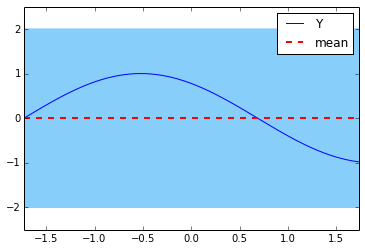

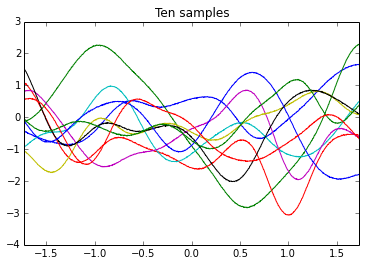

In [9]:
test_case = GP(inputs, outputs, Xnew, Ynew, kernel=kern) # Optional: kernel, normalize
#test_case.prior(inputs)
test_case.plot_prior()